In [7]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

data_dir = "./dataset3"


In [8]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(100, 100),
  batch_size=32)

Found 3366 files belonging to 2 classes.
Using 2693 files for training.


In [9]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(100, 100),
  batch_size=32)

Found 3366 files belonging to 2 classes.
Using 673 files for validation.


In [10]:
class_names = train_ds.class_names
print(class_names)

['non_abstract_images', 'sunflower_dataset']


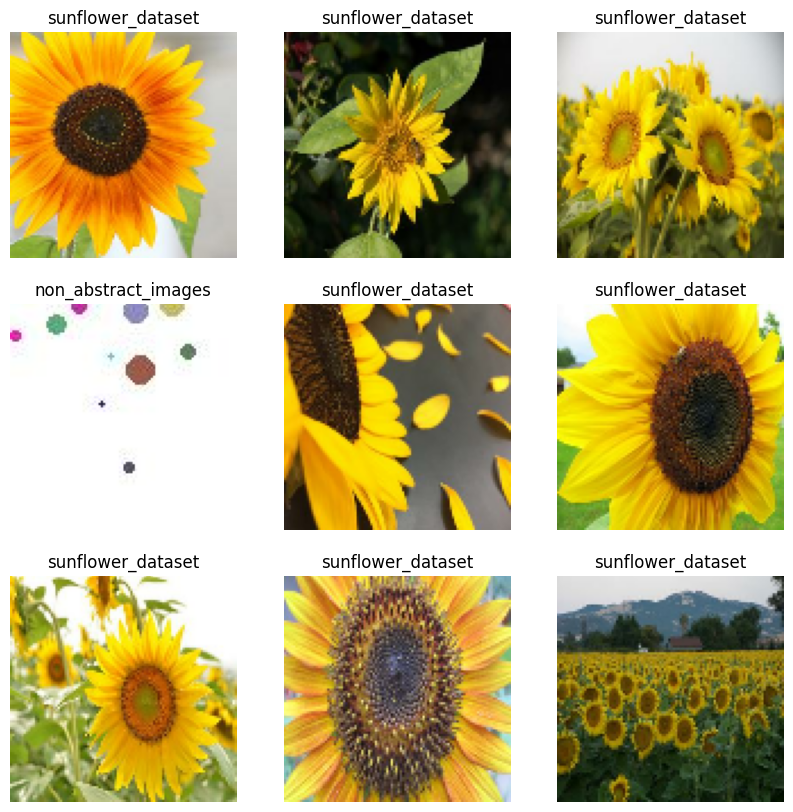

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [12]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [13]:
normalization_layer = layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [14]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(100, 100, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dense(num_classes)
])

In [15]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 100, 100, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 100, 100, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 25, 25, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 25, 25, 64)        1

In [17]:
epochs= 50
es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', min_delta=.01 ,verbose=1, patience=3)
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  #callbacks = [es]
)

Epoch 1/50
85/85 [==============================] - 23s 238ms/step - loss: 0.1106 - accuracy: 0.9670 - val_loss: 0.0246 - val_accuracy: 0.9896
Epoch 2/50
85/85 [==============================] - 16s 194ms/step - loss: 0.0085 - accuracy: 0.9963 - val_loss: 0.0011 - val_accuracy: 1.0000
Epoch 3/50
85/85 [==============================] - 16s 186ms/step - loss: 0.0057 - accuracy: 0.9985 - val_loss: 4.2320e-04 - val_accuracy: 1.0000
Epoch 4/50
85/85 [==============================] - 16s 194ms/step - loss: 3.1046e-04 - accuracy: 1.0000 - val_loss: 0.0086 - val_accuracy: 0.9970
Epoch 5/50
85/85 [==============================] - 16s 190ms/step - loss: 0.0061 - accuracy: 0.9978 - val_loss: 6.3956e-04 - val_accuracy: 1.0000
Epoch 6/50
85/85 [==============================] - 16s 186ms/step - loss: 0.0118 - accuracy: 0.9967 - val_loss: 0.0225 - val_accuracy: 0.9896
Epoch 7/50
85/85 [==============================] - 16s 192ms/step - loss: 0.0415 - accuracy: 0.9941 - val_loss: 0.0534 - val_accu

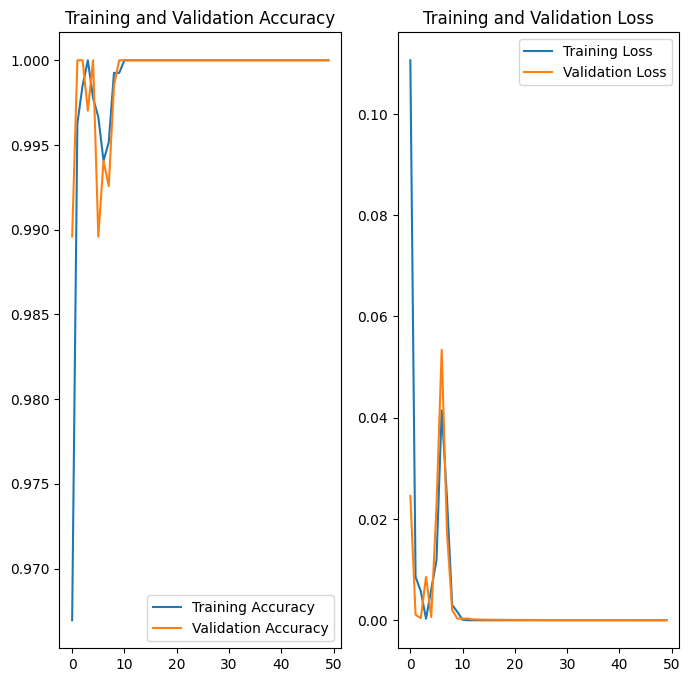

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [19]:
#save the model
model.save("my_model")

INFO:tensorflow:Assets written to: my_model\assets


INFO:tensorflow:Assets written to: my_model\assets


In [20]:
#test prediction with the model
print("abstract_image: ")
img = tf.keras.utils.load_img("./dataset2/abstract_images/abstract_image" + str(0) + ".jpg")
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch
predictions = model.predict(img_array)
print(predictions)

print("non_abstract_image: ")
img = tf.keras.utils.load_img("./dataset2/non_abstract_images/non_abstract_image" + str(0) + ".jpg")
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch
predictions = model.predict(img_array)
print(predictions)

flowers = ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']
for flower in flowers:
    print(flower + ":")
    img = tf.keras.utils.load_img('./dataset2/' + flower + '/' + flower + str(0) + '.jpg')
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    predictions = model.predict(img_array)
    print(predictions)

abstract_image: 
1/1 [==============================] - 0s 160ms/step
[[-37.82871  47.51232]]
non_abstract_image: 
1/1 [==============================] - 0s 64ms/step
[[  3.1589062 -12.847132 ]]
daisy:
1/1 [==============================] - 0s 50ms/step
[[-37.17461  48.70469]]
dandelion:
1/1 [==============================] - 0s 51ms/step
[[-69.74018   85.837715]]
rose:
1/1 [==============================] - 0s 56ms/step
[[-28.08314  31.28562]]
sunflower:
1/1 [==============================] - 0s 59ms/step
[[-95.76153  118.541794]]
tulip:
1/1 [==============================] - 0s 122ms/step
[[-34.574364  44.186466]]


: 